# Exploratory Data analysis

About Dataset
Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents
Inspiration
To explore this type of models and learn more about the subject.

## Imports and settings

Import the libraries we'll use and set some display options for nicer outputs.

In [ ]:
! pip install plotly missingno

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import os
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from lifelines import CoxPHFitter, KaplanMeierFitter

## Load dataset

We'll load the Telco Customer Churn CSV that is in the `data/` folder and show shape and the first rows.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

csv_path = os.path.join("data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = pd.read_csv(csv_path)

print("Dataset path:", csv_path)
print("Shape:", df.shape)

df.head()

In [ ]:
df_clean = df.copy()

df_clean["TotalCharges"] = df_clean["TotalCharges"].replace(" ", np.nan)
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

print("Missing TotalCharges after conversion:", df_clean["TotalCharges"].isna().sum())
if df_clean["TotalCharges"].isna().sum() > 0:
    display(df_clean[df_clean["TotalCharges"].isna()].head())

print("\nValue counts of tenure==0 among TotalCharges NA:")
print((df_clean[df_clean["TotalCharges"].isna()]["tenure"] == 0).sum())

df_clean["TotalCharges_filled"] = df_clean["TotalCharges"].fillna(
    df_clean["MonthlyCharges"] * df_clean["tenure"]
)


## Churn distribution and numeric variable plots

Explore churn counts and distributions for tenure, MonthlyCharges, and TotalCharges_filled.

Churn
No     5174
Yes    1869
Name: count, dtype: int64


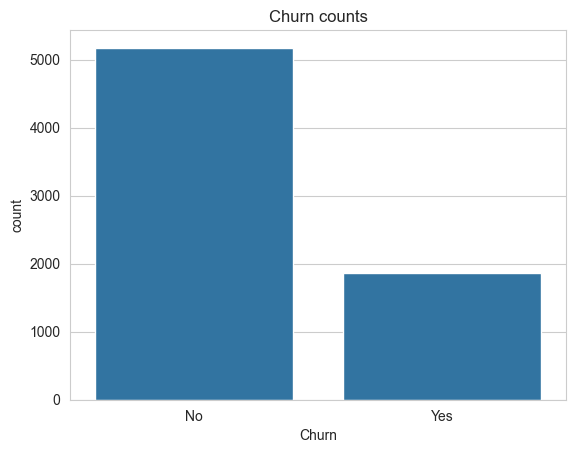

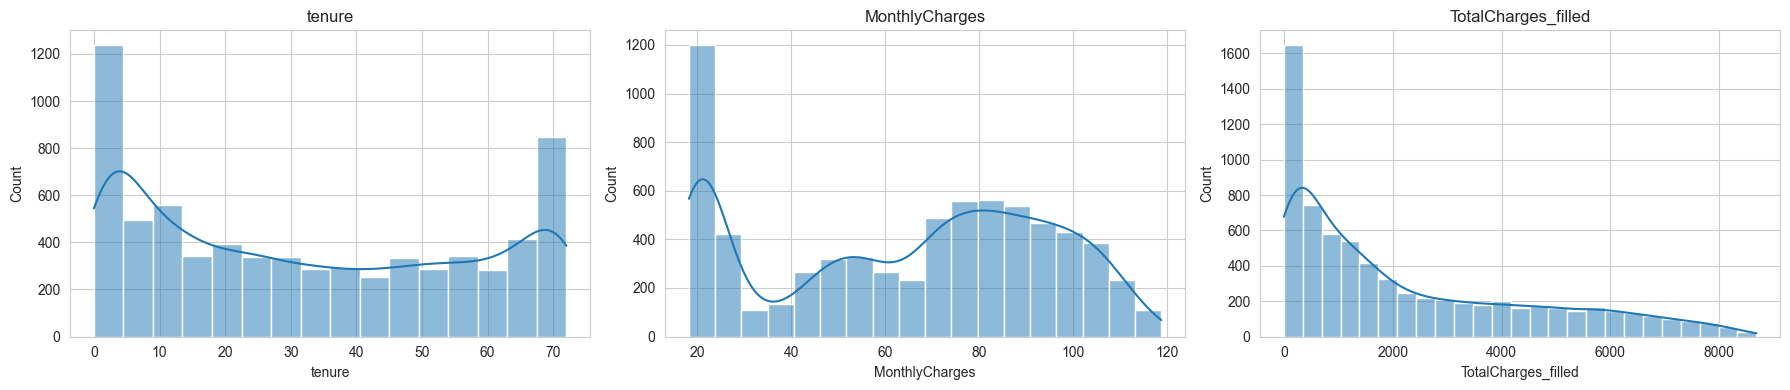

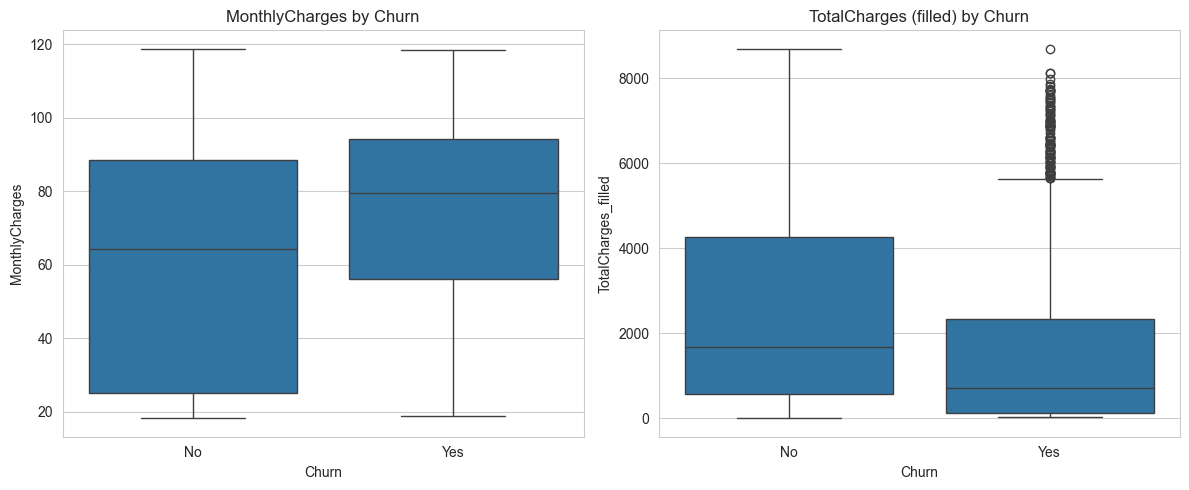

In [ ]:
print(df_clean["Churn"].value_counts())
ax = sns.countplot(data=df_clean, x="Churn")
ax.set_title("Churn counts")

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges_filled"]
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for col, ax in zip(numeric_cols, axes):
    sns.histplot(df_clean[col].dropna(), kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df_clean, ax=axes[0])
axes[0].set_title("MonthlyCharges by Churn")
sns.boxplot(x="Churn", y="TotalCharges_filled", data=df_clean, ax=axes[1])
axes[1].set_title("TotalCharges (filled) by Churn")
plt.tight_layout()

## Categorical counts (selected columns)

Plot counts for some important categorical variables: `Contract`, `PaymentMethod`, `InternetService`, `gender`, `SeniorCitizen`, `Partner`, `Dependents`.

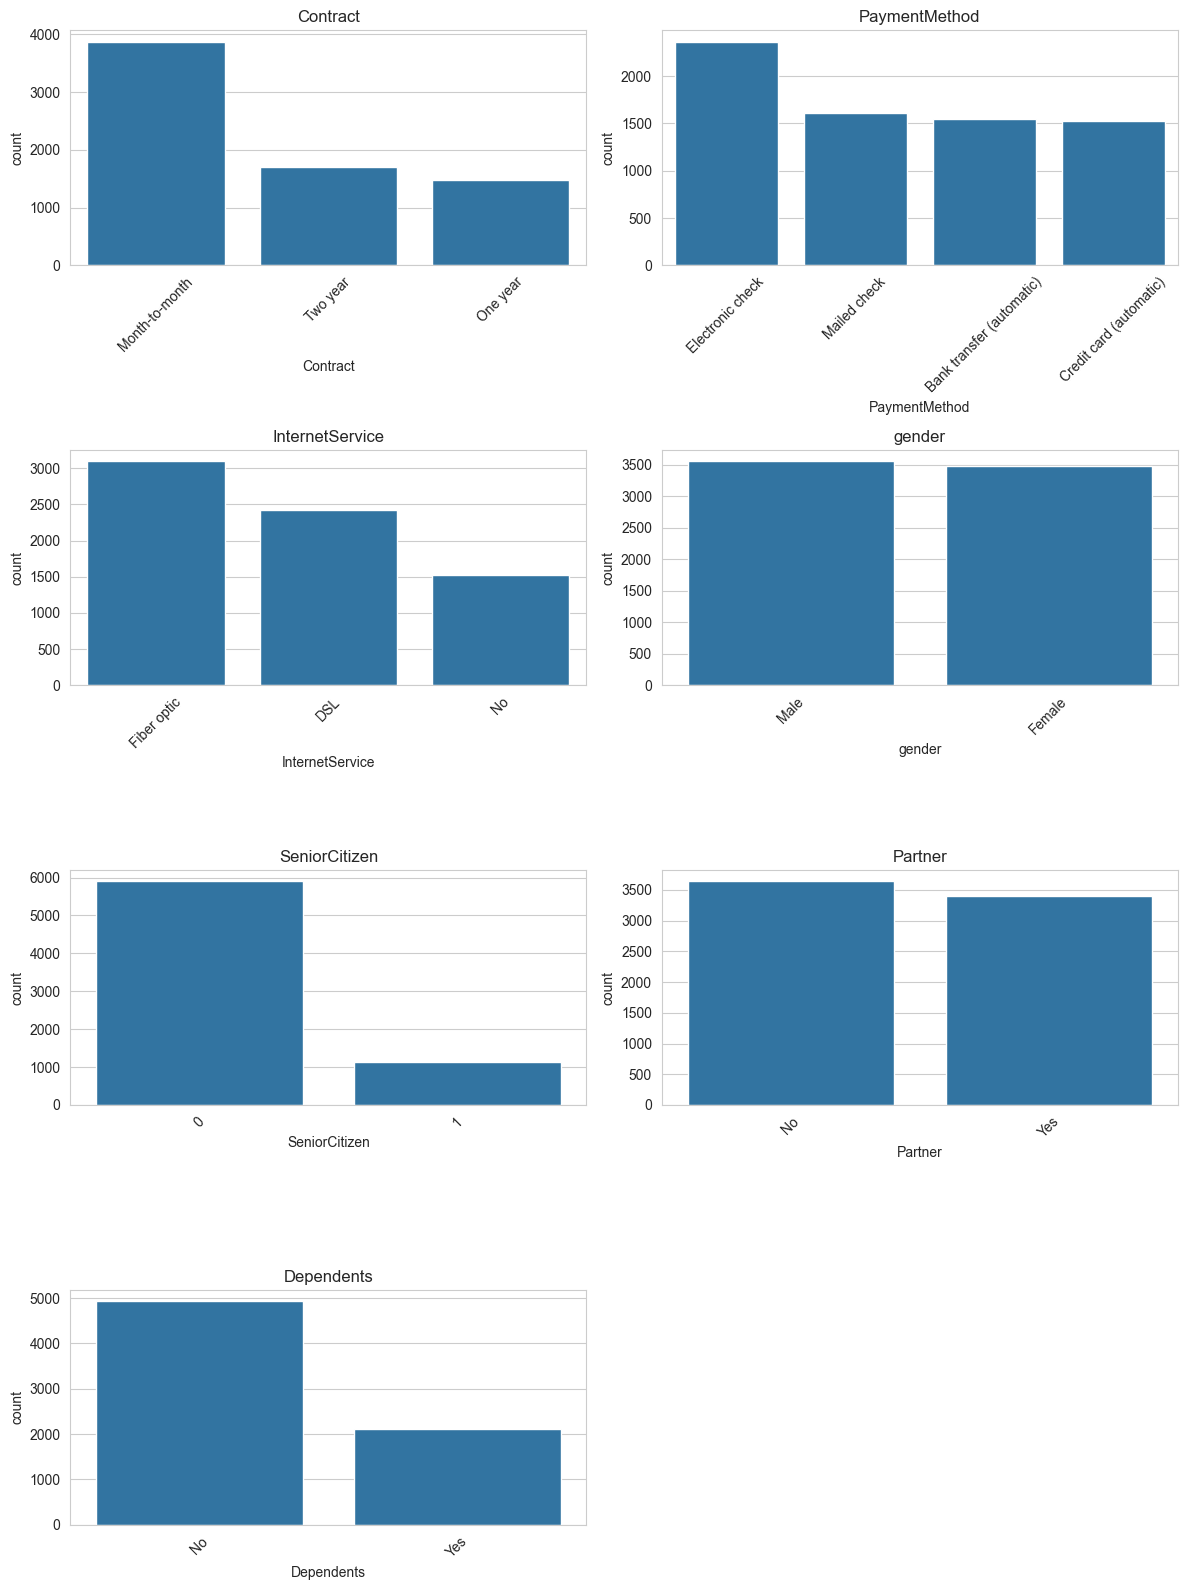

In [31]:
cat_cols = [
    "Contract",
    "PaymentMethod",
    "InternetService",
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
]

ncols = 2
nrows = int(np.ceil(len(cat_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()
for ax, col in zip(axes, cat_cols):
    order = df_clean[col].value_counts().index
    sns.countplot(data=df_clean, x=col, order=order, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis="x", rotation=45)

for ax in axes[len(cat_cols) :]:
    ax.set_visible(False)
plt.tight_layout()

## Correlation heatmap (numeric features)

Show correlations between numeric features (tenure, MonthlyCharges, TotalCharges_filled).

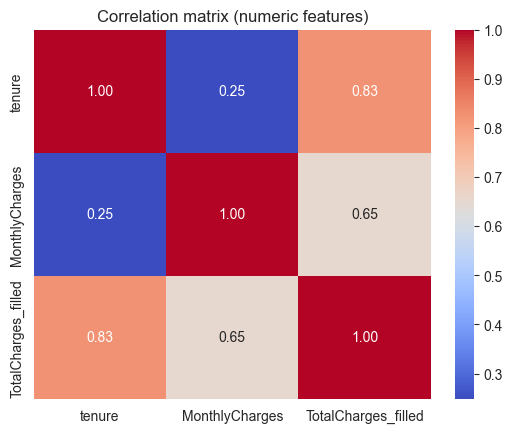

In [32]:
num_for_corr = ["tenure", "MonthlyCharges", "TotalCharges_filled"]
corr = df_clean[num_for_corr].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix (numeric features)")
plt.show()

# HAS TO BE CHECKED

# from course 

### Week 4 - "Supplier Selection as a Classification Problem"
I4.0 Concept: Classifying which supplier to choose.

Telco Analogy: Classifying which customer will churn (leave). This is the most important classification problem for a Telco. We will build a Random Forest model to predict "Churn" (Yes/No).

--- Week 4: Classification (Churn Prediction) ---
Data shape for classification: (7032, 35)
Data split and scaled.
Training Random Forest Classifier...
Evaluating model...

Model Accuracy: 79.10%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Plotting feature importances...


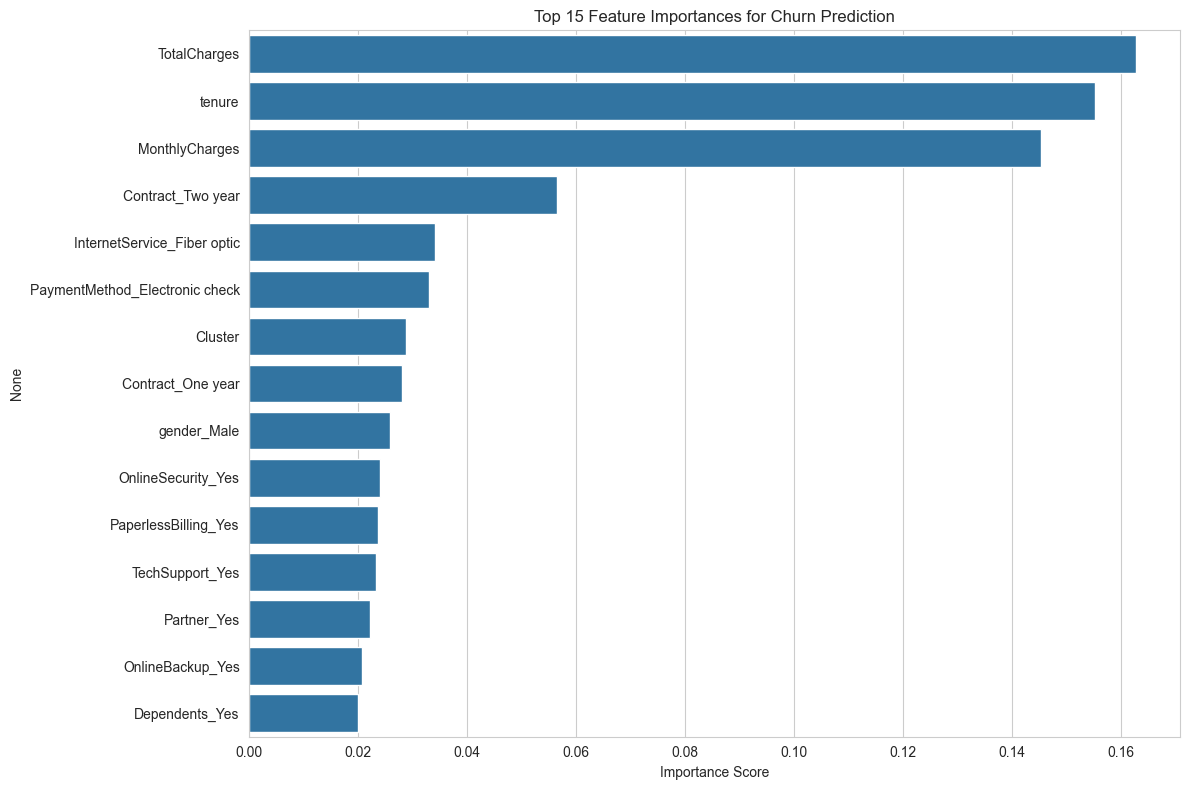

In [ ]:
# --- Week 4: Classification (Predicting Churn) ---
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

print("--- Week 4: Classification (Churn Prediction) ---")

try:
    if "df" not in locals() or "TotalCharges" not in df.columns:
        print("Loading and preprocessing data...")
        df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
        df.dropna(subset=["TotalCharges"], inplace=True)
except NameError:
    print("Error: 'df' not found. Please run your initial data loading cell first.")
    df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df.dropna(subset=["TotalCharges"], inplace=True)


df_class = df.drop(["customerID"], axis=1, errors="ignore")

categorical_cols = df_class.select_dtypes(include=["object", "category"]).columns
target = "Churn"
categorical_cols = categorical_cols.drop(target)

df_class_processed = pd.get_dummies(df_class, columns=categorical_cols, drop_first=True)

df_class_processed["Churn"] = df_class_processed["Churn"].apply(
    lambda x: 1 if x == "Yes" else 0
)

print(f"Data shape for classification: {df_class_processed.shape}")

y = df_class_processed["Churn"]
X = df_class_processed.drop("Churn", axis=1)
num_features_class = ["tenure", "MonthlyCharges", "TotalCharges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler_class = StandardScaler()
X_train[num_features_class] = scaler_class.fit_transform(X_train[num_features_class])
X_test[num_features_class] = scaler_class.transform(X_test[num_features_class])

print("Data split and scaled.")

print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)
rf_model.fit(X_train, y_train)

print("Evaluating model...")
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Plotting feature importances...")
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

plt.figure(figsize=(12, 8))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title("Top 15 Feature Importances for Churn Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Week 6 - "Prognosis"
I4.0 Concept: Predicting the "Remaining Useful Life" (RUL) of a machine before it fails.

Telco Analogy: Predicting the "Remaining Useful Tenancy" of a customer before they churn (fail). This is a classic Survival Analysis problem. We will use the Cox Proportional Hazards model to see which features most impact the timing of churn.

Defaulting to user installation because normal site-packages is not writeable
--- Week 6: Prognosis (Survival Analysis) ---

Plotting overall survival curve...



[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


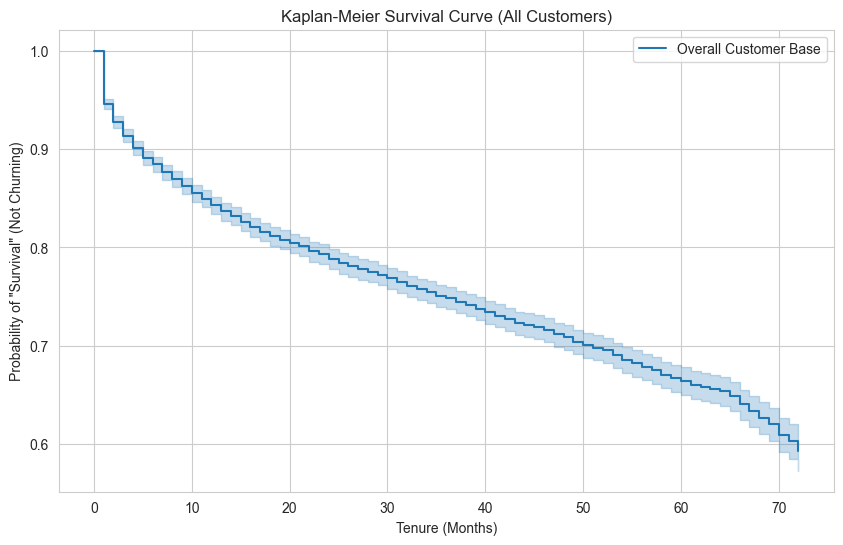


Training Cox Proportional Hazards Model...

An error occurred: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


In [ ]:
# --- Week 6: Prognosis (Survival Analysis / Time-to-Churn) ---

!pip install lifelines

import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("\n--- Week 6: Prognosis (Survival Analysis) ---")

try:
    if 'df_class_processed' not in locals():
        print("Error: 'df_class_processed' not found. Please run Cell 1 (Week 4) first.")
        
    
    df_cox = df_class_processed.copy()
    
    df_cox['tenure'] = df.loc[df_class_processed.index, 'tenure']
    
    if 'TotalCharges' in df_cox.columns:
        df_cox = df_cox.drop('TotalCharges', axis=1)

    print("Plotting overall survival curve...")
    T = df_cox['tenure']
    E = df_cox['Churn']
    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=E, label="Overall Customer Base")

    plt.figure(figsize=(10, 6))
    kmf.plot_survival_function()
    plt.title('Kaplan-Meier Survival Curve (All Customers)')
    plt.xlabel('Tenure (Months)')
    plt.ylabel('Probability of "Survival" (Not Churning)')
    plt.grid(True)
    plt.show()

    print("\nTraining Cox Proportional Hazards Model...")
    
    cph = CoxPHFitter()
    cph.fit(df_cox, duration_col='tenure', event_col='Churn')
    
    print("\nCoxPH Model Summary (Factors influencing *when* churn happens):")
    cph.print_summary(columns=['exp(coef)', 'p'])
    
    print("\nPlotting feature impacts (Hazard Ratios)...")
    plt.figure(figsize=(12, 9))
    cph.plot()
    plt.title('CoxPH Model - Feature Impact on Churn Hazard')
    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"\nError: A required variable is missing: {e}")
    print("Please run Cell 1 (Week 4) first to create the necessary DataFrames.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

# Week 9 - "Dynamic Pricing"
I4.0 Concept: Adjusting prices based on real-time data.

Telco Analogy: We can't build a real-time model, but we can do the core analysis needed for one: Price Sensitivity Analysis. We will see how MonthlyCharges (price) affects the churn rate for different groups. This tells you which customers are most sensitive to price.


--- Week 9: Price Sensitivity Analysis ---

Churn Rate by Monthly Charge Bracket:
         PriceBin  ChurnRate
0    (17.0, 20.0]   0.085434
1    (20.0, 25.0]   0.098291
2    (25.0, 46.0]   0.253582
3    (46.0, 59.0]   0.246066
4    (59.0, 70.0]   0.216714
5    (70.0, 79.0]   0.382228
6    (79.0, 86.0]   0.378963
7    (86.0, 94.0]   0.340845
8   (94.0, 103.0]   0.412356
9  (103.0, 119.0]   0.247159


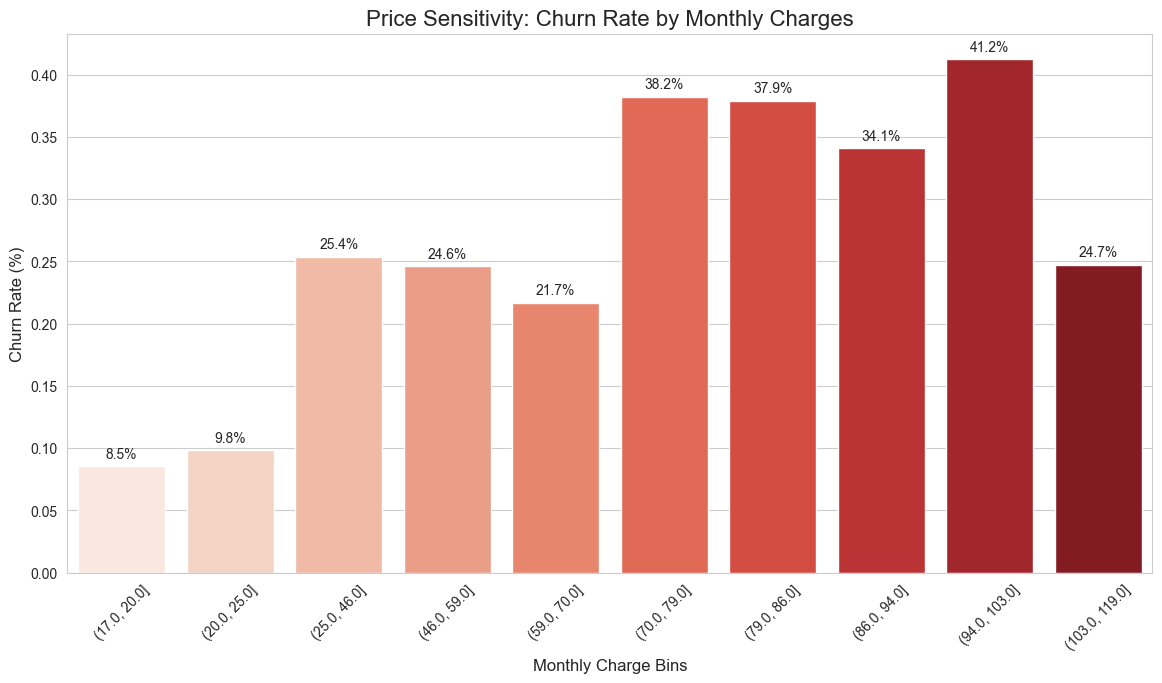


Analysis: This plot shows how sensitive customers are to price.
A company could use this to create targeted discounts (dynamic prices) for
the most price-sensitive brackets (those with the highest churn).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

print("\n--- Week 9: Price Sensitivity Analysis ---")

try:
    if "df" not in locals():
        print("Loading and preprocessing data...")
        df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
        df.dropna(subset=["TotalCharges"], inplace=True)

    df["PriceBin"] = pd.qcut(df["MonthlyCharges"], q=10, precision=0)

    df["Churn_numeric"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

    price_sensitivity = df.groupby("PriceBin")["Churn_numeric"].mean().reset_index()
    price_sensitivity.rename(columns={"Churn_numeric": "ChurnRate"}, inplace=True)

    print("\nChurn Rate by Monthly Charge Bracket:")
    print(price_sensitivity)

    plt.figure(figsize=(14, 7))
    ax = sns.barplot(
        x="PriceBin", y="ChurnRate", data=price_sensitivity, palette="Reds"
    )
    plt.title("Price Sensitivity: Churn Rate by Monthly Charges", fontsize=16)
    plt.xlabel("Monthly Charge Bins", fontsize=12)
    plt.ylabel("Churn Rate (%)", fontsize=12)
    plt.xticks(rotation=45)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height() * 100:.1f}%",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
        )

    plt.show()

    print("\nAnalysis: This plot shows how sensitive customers are to price.")
    print("A company could use this to create targeted discounts (dynamic prices) for")
    print("the most price-sensitive brackets (those with the highest churn).")

except NameError:
    print("\nError: 'df' not found. Please run your initial data loading cell first.")

# Week 8/10 - "Inventory Optimization" / "Logistics 4.0"
I4.0 Concept: Managing physical inventory or logistics.

Telco Analogy: A Telco's "inventory" is its set of services. "Optimizing" this inventory means understanding which services are most valuable and which should be "bundled" (like items in a shipment). We can use Association Rule Mining (Market Basket Analysis) to find these bundles.

In [ ]:
!pip install mlxtend

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import warnings

warnings.filterwarnings('ignore')

print("\n--- Week 8/10: Association Rule Mining (Service Bundles) ---")

try:
    if 'df' not in locals():
        print("Loading and preprocessing data...")
        df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df.dropna(subset=['TotalCharges'], inplace=True)

    service_cols = [
        'PhoneService', 'MultipleLines', 'InternetService', 
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    df_market = df[service_cols]

    df_basket = pd.DataFrame(index=df_market.index)
    df_basket['PhoneService'] = (df_market['PhoneService'] == 'Yes')
    df_basket['MultipleLines'] = (df_market['MultipleLines'] == 'Yes')
    df_basket['Internet_DSL'] = (df_market['InternetService'] == 'DSL')
    df_basket['Internet_Fiber'] = (df_market['InternetService'] == 'Fiber optic')
    df_basket['OnlineSecurity'] = (df_market['OnlineSecurity'] == 'Yes')
    df_basket['OnlineBackup'] = (df_market['OnlineBackup'] == 'Yes')
    df_basket['DeviceProtection'] = (df_market['DeviceProtection'] == 'Yes')
    df_basket['TechSupport'] = (df_market['TechSupport'] == 'Yes')
    df_basket['StreamingTV'] = (df_market['StreamingTV'] == 'Yes')
    df_basket['StreamingMovies'] = (df_market['StreamingMovies'] == 'Yes')
    
    df_basket = df_basket[df_basket.sum(axis=1) > 0]

    print(f"Basket data prepared for {len(df_basket)} customers.")

    print("Running Apriori to find frequent itemsets (min_support=0.1)...")
    frequent_itemsets = apriori(df_basket, min_support=0.1, use_colnames=True)

    print("Generating association rules (min_confidence=0.5)...")
    rules = association_rules(
        frequent_itemsets, 
        metric="confidence", 
        min_threshold=0.5
    )
    
    rules = rules[rules['lift'] > 1].sort_values(by='lift', ascending=False)
    
    print("\n--- Top Association Rules (Service Bundles) ---")
    if rules.empty:
        print("No strong rules found with these settings.")
    else:
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
        
    print("\nAnalysis: This shows which services ('inventory') are bought together.")
    print("e.g., 'If a customer buys (StreamingTV), they are also likely to buy (StreamingMovies)'.")
    print("A company uses this to optimize its 'inventory' by creating smart bundles.")

except NameError:
    print("\nError: 'df' not found. Please run your initial data loading cell first.")

Defaulting to user installation because normal site-packages is not writeable

--- Week 8/10: Association Rule Mining (Service Bundles) ---
Basket data prepared for 7032 customers.
Running Apriori to find frequent itemsets (min_support=0.1)...
Generating association rules (min_confidence=0.5)...

--- Top Association Rules (Service Bundles) ---
                                           antecedents  \
537                   (MultipleLines, StreamingMovies)   
536      (DeviceProtection, StreamingTV, PhoneService)   
535  (PhoneService, StreamingMovies, DeviceProtection)   
539                       (MultipleLines, StreamingTV)   
459                     (TechSupport, StreamingMovies)   
460                         (TechSupport, StreamingTV)   
518      (StreamingMovies, OnlineBackup, PhoneService)   
519          (StreamingTV, OnlineBackup, PhoneService)   
538                  (MultipleLines, DeviceProtection)   
499         (MultipleLines, StreamingTV, PhoneService)   

               


[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
